<h2 style='text-align: center;'> Data Science Technology and Systems </h2>
<h3 style='text-align: center;'> Final Assignment: Predicting Airplane Delays </h3>
<h3 style='text-align: center;'> Part B – On Cloud </h3>
<h3 style='text-align: center;'> V2 - Linear Estimator </h3>
<h4 style='text-align: center;'> Pauline Armamento - u3246782 </h4>

In [1]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
from scipy.io import arff


import os
import boto3
import sagemaker
import subprocess
from sagemaker import image_uris
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# Load CSV files into dataframes
df1 = pd.read_csv('combined_csv_v1.csv')
df2 = pd.read_csv('combined_csv_v2.csv')

In [3]:
# Check for missing values in df1
print(df2.isnull().sum())

target            0
Distance          0
DepHourofDay      0
AWND_O            0
PRCP_O            0
                 ..
Dest_LAX          0
Dest_ORD          0
Dest_PHX          0
Dest_SFO          0
isHoliday_True    0
Length: 86, dtype: int64


In [4]:
# Remove rows with missing values
df2.dropna(inplace=True)

In [5]:
df2.shape

(1635590, 86)

In [7]:
# Split the data into train (70%), and then split the remaining 30% into validation (15%) and test (15%)
class_column = 'target'  # Target variable for stratified splitting

# Split the data into training (70%) and temp (30%)
train_data, temp_data = train_test_split(df2, test_size=0.3, random_state=0, stratify=df2[class_column])

# Split the temp data into validation (15%) and testing (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=0, stratify=temp_data[class_column])

# Print the shapes of the datasets
print("Training set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)
print("Testing set shape:", test_data.shape)

# Save these splits to CSV files for uploading to S3
train_file = 'train.csv'
val_file = 'validation.csv'
test_file = 'test.csv'

train_data.to_csv(train_file, index=False, header=False)
val_data.to_csv(val_file, index=False, header=False)
test_data.to_csv(test_file, index=False, header=False)


Training set shape: (1144913, 86)
Validation set shape: (245338, 86)
Testing set shape: (245339, 86)


In [7]:
import boto3

s3_client = boto3.client('s3')
response = s3_client.list_buckets()

print("Existing buckets:")
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')


Existing buckets:
  c135321a3429026l8211909t1w07796198217-flightbucket-wiycexlqxuki


In [8]:
# Function to upload CSV files to S3
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# Define the S3 bucket and prefix
bucket='c135321a3429026l8211909t1w07796198217-flightbucket-wiycexlqxuki' #change accordingly
prefix = 'flight-delay-project'

# Upload data to S3
upload_s3_csv('train.csv', 'train', train_data)
upload_s3_csv('validation.csv', 'validate', val_data)
upload_s3_csv('test.csv', 'test', test_data)

In [9]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# Instantiate the LinearLearner estimator object with 1 ml.m4.xlarge
num_classes = len(pd.unique(train_data[class_column]))
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')

In [10]:
# Create train, validate, and test records
train_records = classifier_estimator.record_set(train_data.values[:, 1:].astype(np.float32), train_data.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator.record_set(val_data.values[:, 1:].astype(np.float32), val_data.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator.record_set(test_data.values[:, 1:].astype(np.float32), test_data.values[:, 0].astype(np.float32), channel='test')


In [11]:
# Fit the model
classifier_estimator.fit([train_records, val_records, test_records])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-01-07-56-28-150


2024-11-01 07:56:29 Starting - Starting the training job...
2024-11-01 07:56:53 Starting - Preparing the instances for training......
2024-11-01 07:57:39 Downloading - Downloading input data...
2024-11-01 07:58:20 Downloading - Downloading the training image.........
2024-11-01 07:59:41 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/01/2024 07:59:56 INFO 140055738468160] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'lo

In [12]:
# Model Evaluation

sagemaker.analytics.TrainingJobAnalytics(classifier_estimator._current_job_name, 
                                         metric_names = ['test:objective_loss', 
                                                         'test:binary_f_beta',
                                                         'test:precision',
                                                         'test:recall']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,test:objective_loss,0.480989
1,0.0,test:binary_f_beta,0.092383
2,0.0,test:precision,0.566616
3,0.0,test:recall,0.050291


In [25]:
# Hosting the model

import sagemaker

predictor = classifier_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name='flight-delay-endpoint-v2'  
)

print("Model deployed. Endpoint name:", predictor.endpoint_name)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-01-08-38-26-827
INFO:sagemaker:Creating endpoint-config with name flight-delay-endpoint-v2
INFO:sagemaker:Creating endpoint with name flight-delay-endpoint-v2


--------!Model deployed. Endpoint name: flight-delay-endpoint-v2


In [14]:
# Batch Transformer

def batch_linear_predict(test_data, estimator):
    batch_X = test_data.iloc[:,1:];
    batch_X_file='batch-in.csv'
    upload_s3_csv(batch_X_file, 'batch-in', batch_X)

    batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
    batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

    classifier_transformer = estimator.transformer(instance_count=1,
                                           instance_type='ml.m4.xlarge',
                                           strategy='MultiRecord',
                                           assemble_with='Line',
                                           output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                             data_type='S3Prefix',
                             content_type='text/csv',
                             split_type='Line')
    
    classifier_transformer.wait()

    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()),orient="records",lines=True)
    return test_data.iloc[:,0], target_predicted_df.iloc[:,0]

In [15]:
test_labels, target_predicted = batch_linear_predict(test_data, classifier_estimator)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2024-11-01-08-10-30-590
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-01-08-10-31-228


...............................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/01/2024 08:18:27 INFO 140333615888192] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/01/2024 08:18:31 WARNING 140333615888192] Loggers have already been setup.
[11/01/2024 08:18:31 INFO 140333615888192] loaded entry point class algorithm.serve.server_config:config_api
[11/01/2024 08:18:31 INFO 140333615888192] loading entry points
[11/01/202

In [16]:
# Model Performance Metrics 

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

In [18]:
matrix = confusion_matrix(test_labels, target_predicted)
matrix

array([[191858,   1981],
       [ 48910,   2590]])

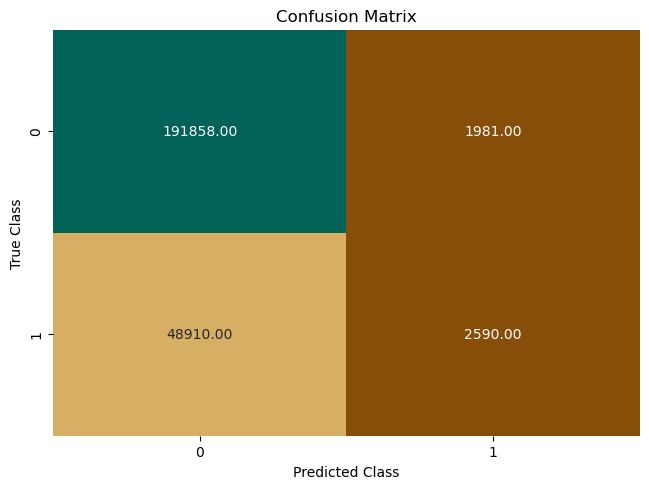

In [19]:
plot_confusion_matrix(test_labels, target_predicted)

Linear estimator model 2, while showing improvement over model 1, still faces challenges in accurately predicting delays. The model correctly identifies 191,858 instances as "No Delay" (true negatives). However, it misclassifies a substantial number of actual delays as "No Delay." Specifically, 48,910 instances of "Delay" were incorrectly labeled as "No Delay" (false negatives). While the model's true positive rate (2,590 correct "Delay" predictions) is higher than model 1, the high false negative rate continues to hinder its overall performance in predicting delays.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

def plot_roc(test_labels, target_predicted):
    # Calculate confusion matrix components
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    
    # Calculate various metrics
    Sensitivity = float(TP) / (TP + FN) * 100 if (TP + FN) > 0 else 0
    Specificity = float(TN) / (TN + FP) * 100 if (TN + FP) > 0 else 0
    Precision = float(TP) / (TP + FP) * 100 if (TP + FP) > 0 else 0
    NPV = float(TN) / (TN + FN) * 100 if (TN + FN) > 0 else 0
    FPR = float(FP) / (FP + TN) * 100 if (FP + TN) > 0 else 0
    FNR = float(FN) / (TP + FN) * 100 if (TP + FN) > 0 else 0
    FDR = float(FP) / (TP + FP) * 100 if (TP + FP) > 0 else 0
    ACC = float(TP + TN) / (TP + FP + FN + TN) * 100 if (TP + FP + FN + TN) > 0 else 0

    # Print metrics
    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print("Specificity or TNR: ", Specificity, "%") 
    print("Precision: ", Precision, "%") 
    print("Negative Predictive Value: ", NPV, "%") 
    print("False Positive Rate: ", FPR, "%")
    print("False Negative Rate: ", FNR, "%") 
    print("False Discovery Rate: ", FDR, "%")
    print("Accuracy: ", ACC, "%") 

    # Calculate AUC
    auc_value = roc_auc_score(test_labels, target_predicted)
    print("Validation AUC:", auc_value)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Create the axis for thresholds
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')




Sensitivity or TPR:  5.029126213592233 %
Specificity or TNR:  98.97801783954725 %
Precision:  56.661562021439515 %
Negative Predictive Value:  79.68583864965444 %
False Positive Rate:  1.0219821604527468 %
False Negative Rate:  94.97087378640778 %
False Discovery Rate:  43.33843797856049 %
Accuracy:  79.25686499089015 %
Validation AUC: 0.5200357202656974


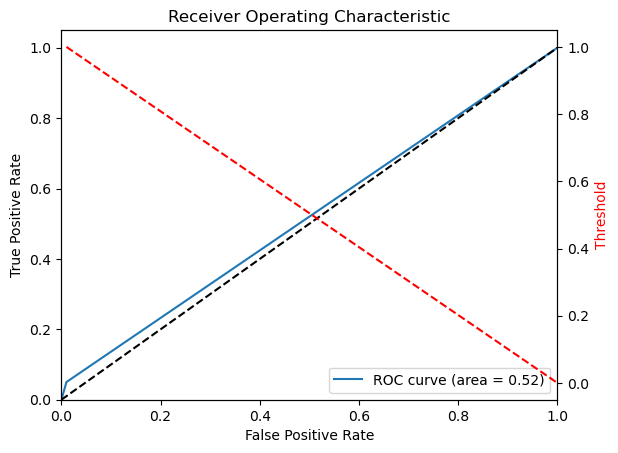

In [23]:
plot_roc(test_labels, target_predicted)

Linear estimator model 2 demonstrates improved performance over model 1, particularly in terms of sensitivity, which has increased to 5.03%. This indicates a higher true positive rate, meaning the model correctly identifies more actual delay instances. However, the model still suffers from a high false negative rate of 94.97%, suggesting that it misses a significant number of true delays. Additionally, while the specificity remains high at 98.98%, the model's precision (56.66%) and negative predictive value (79.69%) suggest that it can still make incorrect positive and negative predictions. Overall, the model's accuracy of 79.26% and validation AUC of 0.5200 indicate a modest improvement over model 1 but still limited predictive power for delay events.